In [1]:
#-------- Import Libraries --------#
import torch
import os
import sys
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [2]:
#!pip install fair-esm

In [3]:
#-------- Import Modules --------#
import encoding as enc
from model import Net
import functions as func

In [4]:
#-------- Set Device --------#

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) avalable.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

No GPUs available. Using CPU instead.


In [5]:
#-------- Seeds --------#

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [6]:
#-------- Directories --------#

DATADIR = '/data/'
TRAINDIR = '../data/train'
VALIDATIONDIR = '../data/validation'
MATRICES = '/data/Matrices'

In [7]:
#-------- Unzip Train --------#

try:
    if len(os.listdir(TRAINDIR)) != 0:
        print("{} already exist.".format(TRAINDIR))
except:
    !unzip ../data/train.zip -d ../data/train

    
#-------- Unzip Validation --------#

try:
    if len(os.listdir(VALIDATIONDIR)) != 0:
        print("{} already exist.".format(VALIDATIONDIR))
except:
    !unzip ../data/validation.zip -d ../data/validation

../data/train already exist.
../data/validation already exist.


In [8]:
print('Train directory:\n\n', '\n'.join(str(p) for p in os.listdir(TRAINDIR)), '\n\n')
print('Validation directory:\n\n','\n'.join(str(p) for p in os.listdir(VALIDATIONDIR)))

Train directory:

 P2_labels.npz
P3_input.npz
P4_input.npz
P2_input.npz
__MACOSX
P1_input.npz
P3_labels.npz
P4_labels.npz
P1_labels.npz 


Validation directory:

 P4_input.npz
__MACOSX
P4_labels.npz


In [9]:
#-------- Import Dataset --------#

data_list = []
target_list = []

import glob
for fp in glob.glob("../data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    data_list.append(data)
    target_list.append(targets)
    
#print(len(data_list))
#print(len(target_list))

X_train = np.concatenate(data_list[ :-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_val = np.concatenate(data_list[-1: ])
y_val = np.concatenate(target_list[-1: ])
nsamples, nx, ny = X_val.shape
print("Val set shape:", nsamples,nx,ny)

p_neg = len(y_train[y_train == 1])/len(y_train)*100
print("Percent positive samples in train:", p_neg)

p_pos = len(y_val[y_val == 1])/len(y_val)*100
print("Percent positive samples in val:", p_pos)

# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device (CPU/GPU):", device)
#device = torch.device("cpu")

Training set shape: 4180 420 54
val set shape: 1526 420 54
Percent positive samples in train: 25.0
Percent positive samples in val: 24.901703800786372

NOTE:
Setting batch-size to 64
Using device (CPU/GPU): cpu


In [15]:
#-------- Define network --------#

print("Initializing network")

# Hyperparameters
input_size = 420
num_classes = 1
learning_rate = 0.01
epochs = 5

# Initialize network
net = Net(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)


Initializing network


In [20]:
#-------- Train network --------#

print("Training")

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
losses = []
val_losses = []

for epoch in range(epochs):
    cur_loss = 0
    val_loss = 0
    
    net.train()
    train_preds, train_targs = [], [] 
    for batch_idx, (data, target) in enumerate(train_ldr):
        X_batch =  data.float().detach().requires_grad_(True)
        target_batch = torch.tensor(np.array(target), dtype = torch.float).unsqueeze(1)
        
        optimizer.zero_grad()
        output = net(X_batch)
        
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        preds = np.round(output.detach().cpu())
        train_targs += list(np.array(target_batch.cpu()))
        train_preds += list(preds.data.numpy().flatten())
        cur_loss += batch_loss.detach()

    losses.append(cur_loss / len(train_ldr.dataset))
        
    net.eval()
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_ldr): ###
            x_batch_val = data.float().detach()
            y_batch_val = target.float().detach().unsqueeze(1)
            
            output = net(x_batch_val)
            
            val_batch_loss = criterion(output, y_batch_val)
            
            preds = np.round(output.detach())
            val_preds += list(preds.data.numpy().flatten()) 
            val_targs += list(np.array(y_batch_val))
            val_loss += val_batch_loss.detach()
            
        val_losses.append(val_loss / len(val_ldr.dataset))
        print("\nEpoch:", epoch+1)
        
        train_acc_cur = accuracy_score(train_targs, train_preds)  
        valid_acc_cur = accuracy_score(val_targs, val_preds) 

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)
        
        from sklearn.metrics import matthews_corrcoef
        print("Training loss:", round(losses[-1].item(),3), "Validation loss:", round(val_losses[-1].item(),3), end = "\n")
        print("MCC Train:", round(matthews_corrcoef(train_targs, train_preds),3), "MCC val:", round(matthews_corrcoef(val_targs, val_preds),3) )
        
print('\nFinished Training ...')

Training

Epoch: 1
Training loss: 0.006 Validation loss: 0.007
MCC Train: 0.544 MCC val: 0.553

Epoch: 2
Training loss: 0.006 Validation loss: 0.007
MCC Train: 0.579 MCC val: 0.509

Epoch: 3
Training loss: 0.006 Validation loss: 0.009
MCC Train: 0.581 MCC val: 0.365

Epoch: 4
Training loss: 0.006 Validation loss: 0.007
MCC Train: 0.58 MCC val: 0.59

Epoch: 5
Training loss: 0.006 Validation loss: 0.007
MCC Train: 0.624 MCC val: 0.554

Finished Training ...


In [21]:
#-------- Save results --------#

results = pd.DataFrame(list(zip( (x[0] for x in val_targs), val_preds)),columns =['target', 'pred'])
print(results)

#results.to_csv('results/df_targets_preds.csv'.format(str(date.today())), index=False)

      target  pred
0        0.0   0.0
1        0.0   0.0
2        1.0   0.0
3        1.0   0.0
4        0.0   0.0
...      ...   ...
1521     1.0   0.0
1522     1.0   1.0
1523     0.0   1.0
1524     1.0   0.0
1525     0.0   0.0

[1526 rows x 2 columns]


AUC:  0.7422430421603747
MCC:  0.5539030719494993


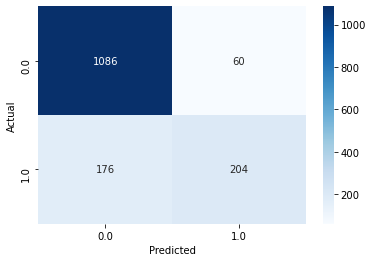

In [22]:
#-------- Performance Evaluation --------#
# The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

print("AUC: ", roc_auc_score(results['target'], results['pred']))
print("MCC: ", matthews_corrcoef(results['target'], results['pred']))
      
confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()